In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd

# Data

In [9]:
n_row = 1000
print()
X, y_true = make_classification(n_samples=n_row, n_classes=2, random_state=1)

model = LogisticRegression(solver='lbfgs')
model.fit(X, y_true)
y_prob = model.predict_proba(X)[:, 1]

# Other functions

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy.stats import chi2, norm
from scipy.special import xlogy

from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve



def phat_PR(rec, prec, x_tp, x_fp, x_tn, x_fn):
    """Fit probability parameters of confusion matrix under the constraint of
    fixed recall and precision
    """
    n4 = x_tp + x_fp + x_tn + x_fn
    n3 = x_tp + x_fp + x_fn
    p_tp = n3 / (n4*(1/rec + 1/prec - 1))  # p_tp hat
    p_fn = ((1-rec)/rec) * p_tp  # remarq: rec >= epilson
    p_fp = ((1-prec)/prec) * p_tp  # remarq: prec >= epilson
    p_tn = 1. - p_fn - p_fp - p_tp
    # prevent negative values to due machine level noise
    if isinstance(p_tn, np.ndarray):
        p_tn[p_tn < 0] = 0
    elif isinstance(p_tn, float) and p_tn < 0:
        p_tn = 0.
    return p_tp, p_fp, p_tn, p_fn


def phat_ROC(fpr, tpr, x_tp, x_fp, x_tn, x_fn):
    """Fit probability parameters of confusion matrix under the constraint of
    fixed FPR and TPR
    """
    n4 = x_tp + x_fp + x_tn + x_fn
    p_tp = (tpr*(x_fn+x_tp)) / n4
    p_fn = (1-tpr)/tpr * p_tp
    p_fp = (fpr*(tpr-p_tp)) / tpr
    p_tn = 1. - p_fn - p_fp - p_tp
    # prevent negative values to due machine level noise
    if isinstance(p_tn, np.ndarray):
        p_tn[p_tn < 0] = 0
    elif isinstance(p_tn, float) and p_tn < 0:
        p_tn = 0.
    return p_tp, p_fp, p_tn, p_fn


def nll(rec, prec, x_tp, x_fp, x_tn, x_fn, phat_fnc):
    """Return -2logp of multinomial distribution fixed at certain point on the curve
    either for precision-recall, or for ROC by choosing the corresponding phat_fnc()

    Two steps:
    1. Fit with fixed recall and precision
    2. Fit with all probability parameters free

    Return the difference in -2 log L
    """
    # optimal fit of x
    n4 = x_tp + x_fp + x_tn + x_fn
    p_fn0 = x_fn / n4
    p_tp0 = x_tp / n4
    p_fp0 = x_fp / n4
    p_tn0 = x_tn / n4
    nll_minimum = -2 * xlogy(x_tp, p_tp0) - 2 * xlogy(x_fp, p_fp0) - 2 * xlogy(x_fn, p_fn0) - 2 * xlogy(x_tn, p_tn0)

    # fit of x constrained to recall and precision
    p_tp, p_fp, p_tn, p_fn = phat_fnc(rec, prec, x_tp, x_fp, x_tn, x_fn)
    nll_value = -2 * xlogy(x_tp, p_tp) - 2 * xlogy(x_fp, p_fp) - 2 * xlogy(x_fn, p_fn) - 2 * xlogy(x_tn, p_tn)

    # return the difference
    return nll_value - nll_minimum


def get_grid(X_term1, X_term2, Y_term1, Y_term2, n_bins=100, epsilon=1e-4, n_sigma=6):
    """For a point on the curve x=X_term1/(X_term1+X_term2) and y=Y_term1/(Y_term1+Y_term2),
    make a rough estimate for the range of (x,y) values grid to scan.
    Works for both (Recall,Precision) or (FPR,TPR).
    """
    x = get_range_axis(X_term1, X_term2, n_bins, epsilon, n_sigma)
    y = get_range_axis(Y_term1, Y_term2, n_bins, epsilon, n_sigma)

    RX, PY = np.meshgrid(x, y)

    return RX, PY


def get_range_axis(term1, term2, nbins, epsilon, n_sigma):
    """
    Works for all of those: Recall, Precision, FPR and TPR = term1/(term1+term2)

    FPR       = x_fp / (x_fp + x_tn) # x-axis
    TPR       = x_tp / (x_tp + x_fn) # y-axis == recall
    recall    = x_tp / (x_tp + x_fn) # x-axis
    precision = x_tp / (x_tp + x_fp) # y-avis

    # Sigma estimation based on the covariance matrix first-order approximation:
    sigma FPR       = (x_fp*x_tn) / (x_fp + x_tn)**3
    sigma TPR       = (x_tp*x_fn) / (x_tp + x_fn)**3
    sigma recall    = (x_tp*x_fn) / (x_tp + x_fn)**3 == TPR
    sigma precision = (x_tp*x_fp) / (x_tp + x_fp)**3
    In all these case we can notice that:
    sigma XXXX      = (term1 * term2) / (term1 + term2)**3

    Remark: if you observer at least one fp, precision cannot be 100%
    """
    V = term1/(term1+term2)

    # Get sigma estimation based on the covariance matrix first-order approximation
    # If we get one the term of the product to be zero (like x_fp * x_tn)
    # we set it in order to have at least one x_fp, or x_tn, so that we have a non-zero sigma
    if term1 == 0:
        term1 = 1
    if term2 == 0:
        term2 = 1
    sigma_V = np.sqrt((term1 * term2) / (term1+term2)**3)

    # We intoduce an epsilon to prevent division by zero at the edge because in phat() we have some divisions by precision, recall and TPR
    # but most importantly, we need an epsilon to have nice contour plots: (for X and Y)
    # if X == 1, its means that we can have a grid including value 1, and the contour will have finite values
    # if X <  1, its means that the probability to have value 1 is 0, and therefore the nll is infinity,
    #            and therefore we have a plotting issue for the contour, so we set it to 1-epsilon so the contour knows how to extrapolate
    max_V_clip = 1 if V == 1 else 1-epsilon

    # Ranges of values for the axis to scan, with clipping to not draw outside of the square (0,1)
    V_max = min(V + n_sigma * sigma_V, max_V_clip)  # max_V_clip to have nice contours
    V_min = max(V - n_sigma * sigma_V, epsilon)  # epsilon to prevent division by 0

    return np.linspace(V_max, V_min, nbins)


def get_scaling_factor(norm_nstd):
    # Get the scale for 2 degrees of freedom confidence interval
    # We use chi2 because the equation of an ellipse is a sum of squared variable,
    # more details here https://www.visiondummy.com/2014/04/draw-error-ellipse-representing-covariance-matrix/
    # norm_nstd = 1  # number of standard deviation
    norm_pct = 2. * (norm.cdf(norm_nstd) - 0.5)
    chi2_quantile = chi2.ppf(norm_pct, 2)
    scale = np.sqrt(chi2_quantile)
    return scale

def get_confusion_matrix(y_true, y_prob, thresholds):
    N = len(y_true)

    # remark: computing them with metrics.confusion_matrix() takes too much time
    P = np.array([sum(y_true)] * len(thresholds))
    # we use ">= thr" like in precision_recall_curve():
    TP = np.array([((y_prob >= thr) & y_true).sum() for thr in thresholds])
    PP = np.array([(y_prob >= thr).sum() for thr in thresholds])
    FN = P - TP
    FP = PP - TP
    TN = N - TP - FP - FN

    return TP, FP, TN, FN

# Plot Function

In [79]:
def plot_precision_recall_curve_with_CI(y_true, y_prob, norm_nstd=1, n_bins=100):
    t0 = time.time()
    precision, recall, thresholds = precision_recall_curve(y_true, y_prob)

    # add zero threshold (missing by default)
    print(thresholds[0])
    thresholds = np.concatenate([[0.], thresholds])
    precision = np.concatenate([[precision[0]], precision])  # precision stay the same here
    recall = np.concatenate([[1.], recall])

    scale = get_scaling_factor(norm_nstd)

    # Plot precision-recall curve
    fig, ax = plt.subplots()#(figsize=(10, 7.5))

    TP, FP, TN, FN = get_confusion_matrix(y_true, y_prob, thresholds)

    n_thresholds = len(thresholds)
    print(f"{n_thresholds=}")
    # For each point in the precision-recall curve plot an ellipse
    for i, (r, p, x_tp, x_fp, x_tn, x_fn) in enumerate(zip(recall, precision, TP, FP, TN, FN)):
        if (r == 1 or p == 1):  # tails
            color = 'lightblue'
        else:
            color = 'C0'

        # x-axis: rec = x_tp / (x_tp + x_fn)
        X_term1 = x_tp
        X_term2 = x_fn

        # y-axis: prec = x_tp / (x_tp + x_fp)  # same as TPR
        Y_term1 = x_tp
        Y_term2 = x_fp

        RX, PY = get_grid(X_term1, X_term2, Y_term1, Y_term2, n_bins=n_bins)
        chi2 = nll(RX, PY, x_tp, x_fp, x_tn, x_fn, phat_PR)
        levels = [scale**2]
        levels = [0.0] + levels#.tolist()
        CS = ax.contourf(RX, PY, chi2, levels=levels, alpha=0.50, colors='lightblue')

    # Plot line after the contours/ellipses to see it well
    ax.plot(recall, precision, label='classifier') #, color='black')  # or adjust_lightness
    
    ax.set_xlim((0, 1.01))
    ax.set_ylim((0, 1.01))
    ax.spines['right'].set_visible(False)
    ax.spines['right'].set_linestyle('dotted')
    ax.spines['top'].set_visible(False)
    ax.spines['top'].set_linestyle('dotted')
    ax.axvline(1, color='black', linewidth=0.5, ls='dotted')
    ax.axhline(1, color='black', linewidth=0.5, ls='dotted')
    ax.set_aspect(1)

    ax.set_xlabel('Recall (True Positive Rate)')
    ax.set_ylabel('Precision (1-FDR)')
    ax.set_title(f'Precision-Recall Curve ±{norm_nstd}σ uncertainty')
    t1 = time.time()
    #ax.set_title(f'PR n_row={len(y_true)} {n_bins=} {n_thresholds=} time:{t1-t0:.2f} sec')
    # ax.legend(loc="lower left")

    return fig, n_thresholds


def plot_ROC_curve_with_CI(y_true, y_prob, norm_nstd=1, n_bins=100):
    t0 = time.time()

    fpr, tpr, thresholds = roc_curve(y_true, y_prob)

    # No need to add zero threshold (missing by default)
    #print(thresholds[:3]) # first value 1.999
    #print(fpr[:3])
    #print(tpr[:3])

    scale = get_scaling_factor(norm_nstd)

    # Plot precision-recall curve
    fig, ax = plt.subplots()#figsize=(10, 7.5))

    TP, FP, TN, FN = get_confusion_matrix(y_true, y_prob, thresholds)

    n_thresholds = len(thresholds)
    print(f"{n_thresholds=}")
    # For each point in the precision-recall curve plot an ellipse
    for i, (f, t, x_tp, x_fp, x_tn, x_fn) in enumerate(zip(fpr, tpr, TP, FP, TN, FN)):

        # x-axis: FPR = x_fp / (x_fp + x_tn)
        X_term1 = x_fp
        X_term2 = x_tn

        # y-axis: TPR = x_tp / (x_tp + x_fn)  # same as rec
        Y_term1 = x_tp
        Y_term2 = x_fn

        RX, PY = get_grid(X_term1, X_term2, Y_term1, Y_term2, n_bins=n_bins)
        chi2 = nll(RX, PY, x_tp, x_fp, x_tn, x_fn, phat_ROC)
        levels = [scale**2]
        levels = [0.0] + levels#.tolist()
        CS = ax.contourf(RX, PY, chi2, levels=levels, alpha=0.50, colors='lightblue')

    # Plot line after the contours/ellipses to see it well
    ax.plot(fpr, tpr, label='classifier')#, color='black')  # or adjust_lightness
            
    ax.set_xlim((0, 1.01))
    ax.set_ylim((0, 1.01))
    ax.spines['right'].set_visible(False)
    ax.spines['right'].set_linestyle('dotted')
    ax.spines['top'].set_visible(False)
    ax.spines['top'].set_linestyle('dotted')
    ax.axvline(1, color='black', linewidth=0.5, ls='dotted')
    ax.axhline(1, color='black', linewidth=0.5, ls='dotted')
    ax.set_aspect(1)
    
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate (Recall)')
    ax.set_title(f'ROC Curve ±{norm_nstd}σ sampling uncertainty')
    t1 = time.time()
    #ax.set_title(f'ROC n_row={len(y_true)} {n_bins=} {n_thresholds=} time:{t1-t0:.2f} sec')
    # ax.legend(loc="lower left")

    return fig, n_thresholds

# ROC

n_row=1000 n_bins=100
n_thresholds=230


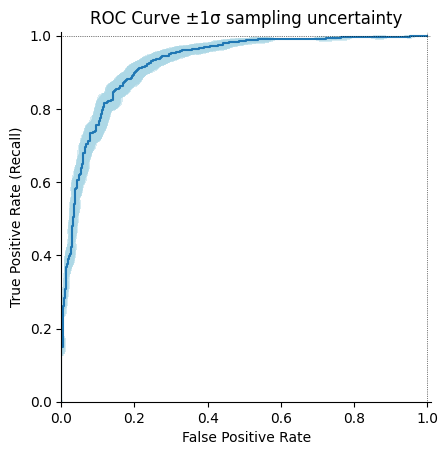

CPU times: user 406 ms, sys: 8.26 ms, total: 414 ms
Wall time: 414 ms


In [80]:
%%time
n_bins = 100
print(f"{n_row=} {n_bins=}")
plot_ROC_curve_with_CI(y_true, y_prob, n_bins=n_bins)
plt.show()

# PR

0.0003339296183491483
n_thresholds=1001


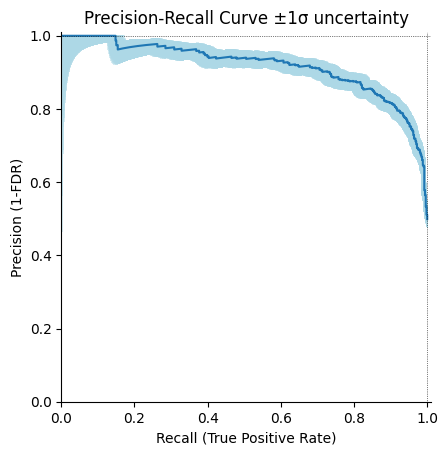

CPU times: user 2.16 s, sys: 12.1 ms, total: 2.17 s
Wall time: 2.17 s


In [81]:
%%time
plot_precision_recall_curve_with_CI(y_true, y_prob, n_bins=n_bins)
plt.show()

# Timing loop

In [ ]:
n_binss = [50, 100, 200, 500, 1000]
n_rows = [100, 1000, 10000, 100000]
df = []
for n_row in n_rows:
    X, y_true = make_classification(n_samples=n_row, n_classes=2, random_state=1)

    model = LogisticRegression(solver='lbfgs')
    model.fit(X, y_true)
    y_prob = model.predict_proba(X)[:, 1]

    for n_bins in n_binss:
        print(f"{n_row=} {n_bins=}")
        
        t0 = time.time()
        fig, n_thresholds = plot_ROC_curve_with_CI(y_true, y_prob, n_bins=n_bins)
        t1 = time.time()
        plt.savefig(f'curves/ROC_{n_row=}_{n_bins=}_{n_thresholds=}.png')
        plt.close(fig)
        t2 = time.time()
        p = {'Curve': 'ROC', 'n_row': n_row, 'n_bins': n_bins, 'n_thresholds': n_thresholds, 'time1': t1-t0, 'time2': t2-t0}
        print(p)
        df.append(p)

        t0 = time.time()
        fig, n_thresholds = plot_precision_recall_curve_with_CI(y_true, y_prob, n_bins=n_bins)
        t1 = time.time()
        plt.savefig(f'curves/PRC_{n_row=}_{n_bins=}_{n_thresholds=}.png')
        plt.close(fig)
        t2 = time.time()
        p = {'Curve': 'PRC', 'n_row': n_row, 'n_bins': n_bins, 'n_thresholds': n_thresholds, 'time1': t1-t0, 'time2': t2-t0}
        print(p)
        df.append(p)
        
        print()

In [82]:
results_df = pd.DataFrame(df)
results_df["Curve"] = np.where(results_df.index % 2, "ROC", "PRC")
results_df['time1'] = results_df['time1'].apply(lambda x: float("{:.2f}".format(x)))
results_df['time2'] = results_df['time2'].apply(lambda x: float("{:.2f}".format(x)))
print("Execution time in seconds. time1: just computation. time2: computation and rendering")
results_df

Execution time in seconds. time1: just computation. time2: computation and rendering


,Curve,n_row,n_bins,n_thresholds,time1,time2
0,PRC,100,50,6,0.01,0.06
1,ROC,100,50,101,0.11,0.17
2,PRC,100,100,6,0.01,0.06
3,ROC,100,100,101,0.14,0.19
4,PRC,100,200,6,0.08,0.13
5,ROC,100,200,101,0.25,0.30
6,PRC,100,500,6,0.07,0.12
7,ROC,100,500,101,1.23,1.29
8,PRC,100,1000,6,0.27,0.32
9,ROC,100,1000,101,4.57,4.63


In [83]:
results_df.to_csv('curves/execution_times.csv')